In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

# Problems

### 1) Heteroskedastic residuals present

### 2) Multicollinearity present

In [4]:
data=pl.read_csv("errorAnalysed.csv").drop("index")
data.head()

curbweight,cylindernumber,carvolume,enginepower,averagempg,price
i64,i64,f64,f64,f64,f64
2548,0,528019.904,4.6132e6,23.7,13495.0
2548,0,528019.904,4.6132e6,23.7,16500.0
2823,1,587592.64,4.4555e6,22.15,16500.0
2337,0,634816.956,3.8413e6,26.7,13950.0
2824,1,636734.832,4.9171e6,19.8,17450.0


In [5]:
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(data.drop("price"))
print(f"Condition number: {condition_number:.4f}")

Condition number: 16190631.9122


Very high condition number indicates high multicollinearity

In [6]:
condition_number = condition_index(data.drop("price","cylindernumber","averagempg","curbweight"))
print(f"Condition number: {condition_number:.4f}")

Condition number: 23.8113


Multicollinearity reduced

In [7]:
data=data.drop("cylindernumber","averagempg","curbweight")

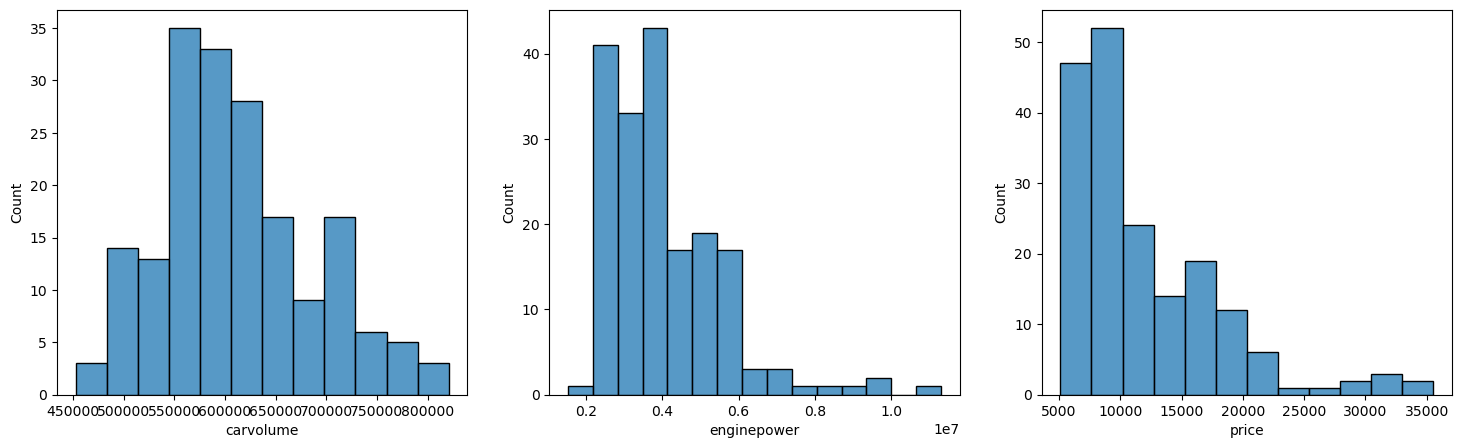

In [8]:
fig,[ax1,ax2,ax3]=  plt.subplots(ncols=3,figsize=(18,5))
sns.histplot(data.to_pandas(),x="carvolume",ax=ax1)
sns.histplot(data.to_pandas(),x="enginepower",ax=ax2)
sns.histplot(data.to_pandas(),x="price",ax=ax3)
plt.show()

enginepower,price is much skewed which is a violation of Assumptions, Applying log (simple way) to make if more normal

In [9]:
df=data.with_columns(data['enginepower'].log10())
df=df.with_columns(data['price'].log10())

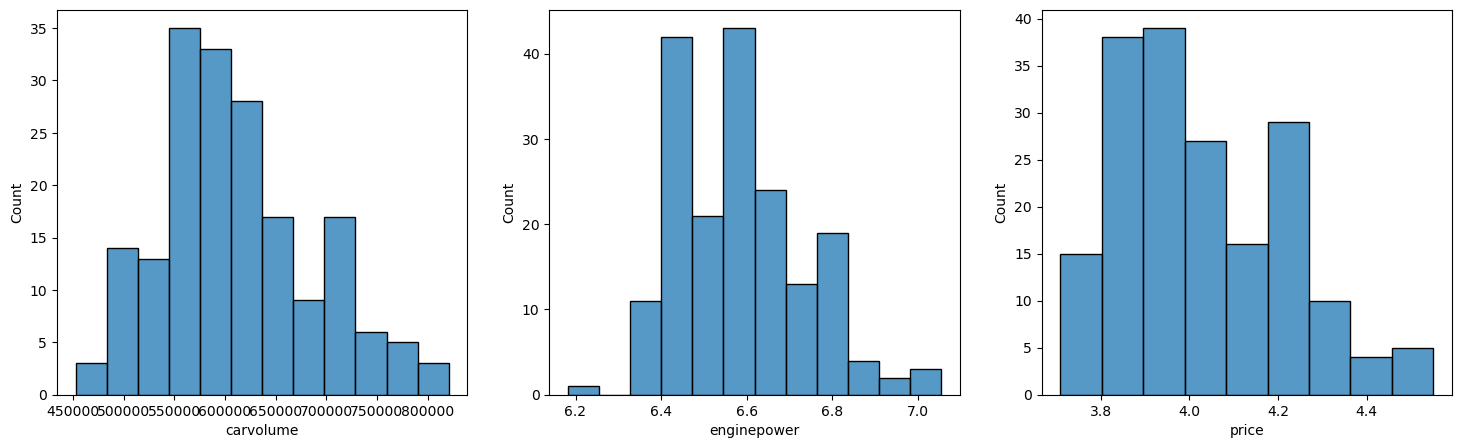

In [10]:
fig,[ax1,ax2,ax3]=  plt.subplots(ncols=3,figsize=(18,5))
sns.histplot(df.to_pandas(),x="carvolume",ax=ax1)
sns.histplot(df.to_pandas(),x="enginepower",ax=ax2)
sns.histplot(df.to_pandas(),x="price",ax=ax3)
plt.show()

# Using models robust to outliers

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
X=df.drop('price').to_pandas()
y=df['price'].to_pandas()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [12]:
huber_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("huber", HuberRegressor())
])
param_grid = {
    'huber__epsilon': np.linspace(1, 4, 30),
    'huber__alpha': np.linspace(0, 4, 30),
    'huber__max_iter': np.arange(100, 200, 10)
}

kf = KFold(n_splits=3)
grid_search = GridSearchCV(huber_pipe, param_grid, cv=kf, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_epsilon = grid_search.best_params_['huber__epsilon']
best_alpha = grid_search.best_params_['huber__alpha']
best_max_iter = grid_search.best_params_['huber__max_iter']
huber_pipe.set_params(huber__epsilon=best_epsilon, huber__alpha=best_alpha, huber__max_iter=best_max_iter)
huber_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('huber',
                 HuberRegressor(alpha=3.7241379310344827, epsilon=1.0))])

cross validation scores train: [0.77653072 0.69983485 0.71122637]
cross validation scores test: [0.75420842 0.92690929 0.90566258]
Mean Absolute Error: 0.06120649457926793
R-squared: 0.8785764302148457


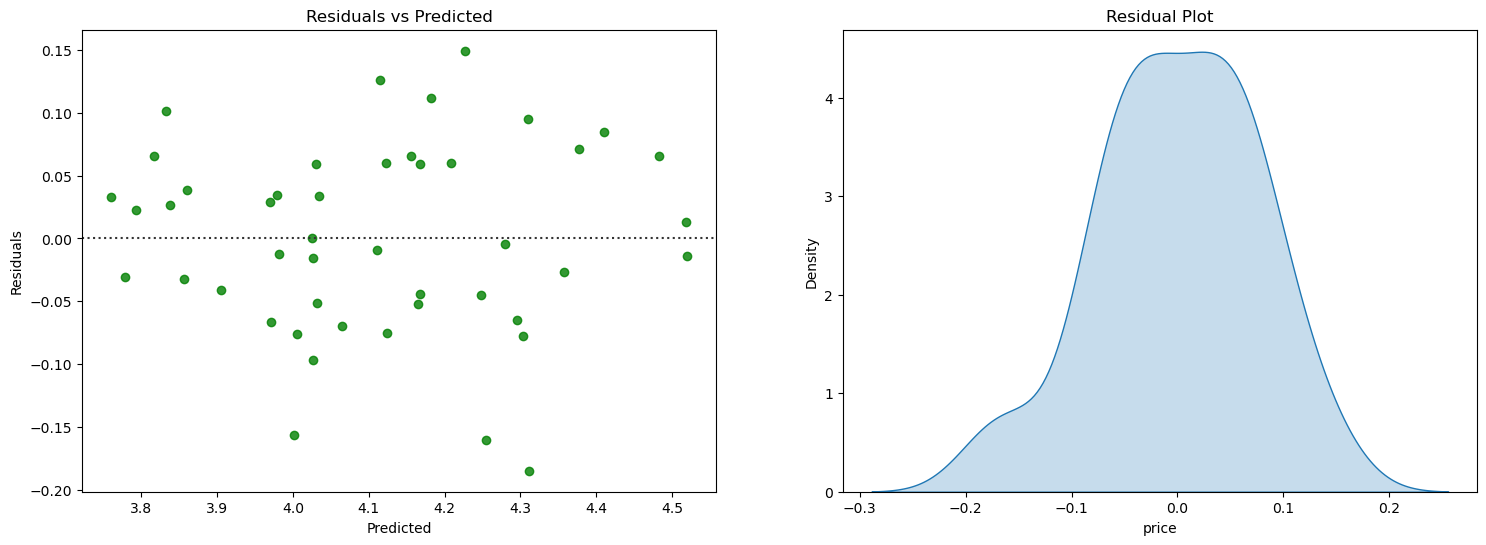

In [13]:
cv_scores_train = cross_val_score(huber_pipe, X_train, y_train, cv=kf, n_jobs=-1)
cv_scores_test = cross_val_score(huber_pipe, X_test, y_test, cv=kf, n_jobs=-1)
predictions = cross_val_predict(huber_pipe, X_test, y_test, cv=kf)

residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'cross validation scores train: {cv_scores_train}')
print(f'cross validation scores test: {cv_scores_test}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))

# Residuals vs Predicted
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')

# KDE plot of residuals
sns.kdeplot(residuals, ax=ax2, fill=True)
ax2.set_title("Residual Plot")

plt.show()

Regularization working,increased bias on train set to increase variance over test set

In [14]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant

# Fit the model and calculate residuals
X_with_const = add_constant(X_train)
model = OLS(y_train, X_with_const).fit()
residuals = model.resid

# Perform Breusch-Pagan test
lm_test = het_breuschpagan(residuals, model.model.exog)
lm_stat, lm_pvalue, fvalue, fpvalue = lm_test
print(f'Breusch-Pagan test: LM statistic = {lm_stat}, p-value = {lm_pvalue}')

Breusch-Pagan test: LM statistic = 2.4090163039610895, p-value = 0.29983943868551366


# Homoscedasticity Passed

In [15]:
from statsmodels.stats.stattools import durbin_watson
# Perform the Durbin-Watson test
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_statistic}')

Durbin-Watson statistic: 1.993353614844449


# No Auto Correlation

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm
a=sm.add_constant(X_train)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = a.columns
vif_data['VIF'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
print(vif_data)

       feature          VIF
0        const  3048.051848
1    carvolume     1.574865
2  enginepower     1.574865


# No multicollinearity

In [19]:
predictions_logless = np.power(10, predictions)

# Inverse transform y_test_log to get it back to the original scale
y_test_logless = np.power(10,y_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_logless, predictions_logless)
r2 = r2_score(y_test_logless, predictions_logless)

print(f'Mean Absolute Error (Original Scale): {mae}')
print(f'R-squared (Original Scale): {r2}')

Mean Absolute Error (Original Scale): 2035.6134478257718
R-squared (Original Scale): 0.8795996676331314


Absolute error increased little from 1820 to 2090,but reults more reliable by the assumptions of linear regression

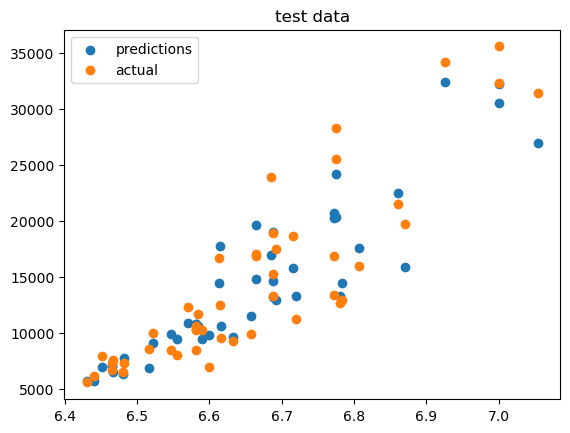

In [20]:
plt.scatter(X_test["enginepower"],predictions_logless)
plt.scatter(X_test["enginepower"],y_test_logless)
plt.title("test data")
plt.legend(["predictions", "actual"])

Mean Absolute Error (Original Scale): 2081.3954850702357
R-squared (Original Scale): 0.7655252240165065


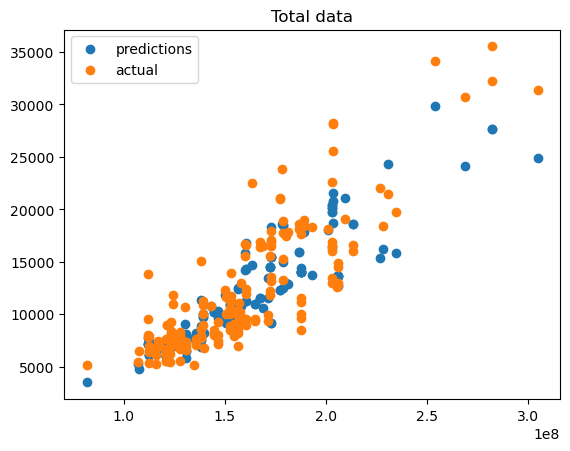

In [21]:
predictions = cross_val_predict(huber_pipe, X, y, cv=kf)

residuals = y - predictions
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)
predictions_logless = np.power(10, predictions)

# Inverse transform y_log to get it back to the original scale
y_logless = np.power(10,y)

# Calculate evaluation metrics
mae = mean_absolute_error(y_logless, predictions_logless)
r2 = r2_score(y_logless, predictions_logless)

print(f'Mean Absolute Error (Original Scale): {mae}')
print(f'R-squared (Original Scale): {r2}')
plt.scatter(X["enginepower"].pow(10),predictions_logless)
plt.scatter(X["enginepower"].pow(10),y_logless)
plt.title("Total data")
plt.legend(["predictions", "actual"])
plt.show()

# Covers good amount of variance reliably